In [1]:
from sklearn import feature_extraction
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import matplotlib
import sklearn
import matplotlib.pyplot as plt
import mglearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
sns.set()

%matplotlib inline

## Data Processing

In [6]:
# Original Data
salary_uk = pd.read_csv("http://www.webpages.uidaho.edu/~stevel/Datasets/salary_uk.csv")
salary_uk.head()
salary_uk

salary_uk['Title'] = salary_uk['Title']

import string
salary_uk['Title'] = salary_uk['Title'].str.lower()
salary_uk['Title'] = salary_uk['Title'].str.replace('[^\w\s]','')
salary_uk['Title'] = salary_uk['Title'].str.replace('\d+', '')
salary_uk['Title'] = salary_uk['Title'].str.strip(' ')

# Vectorize paragraphs in Title and Description columns
vec = TfidfVectorizer(stop_words='english', max_features=10000)

X = vec.fit_transform(salary_uk['Title'].values.astype('str'))
Title = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

X = vec.fit_transform(salary_uk['FullDescription'].values.astype('str'))
FullDescription = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

# merge vectorized columns with original dataframe to make a new vectorized dataframe
salary_uk2 =pd.merge(salary_uk, FullDescription, left_index=True, right_index=True)
salary_uk2 =pd.merge(salary_uk2, Title , left_index=True, right_index=True)
salary_uk2.head()

# drop old columns
salary_uk2 = salary_uk2.drop(['Title','FullDescription'], axis = 1)

# get dummy variables for categorical data
salary_uk2 = pd.get_dummies(salary_uk2, columns =[u'LocationNormalized',
       u'ContractType', u'ContractTime', u'Company', u'Category'])

salary_uk2 = salary_uk2.drop([u'LocationRaw',
       u'SalaryRaw', u'SourceName'], axis = 1)
salary_uk2.head()

,Id,SalaryNormalized,00,000,00am,00pm,01,010,011,013,...,Category_Other/General Jobs,"Category_PR, Advertising & Marketing Jobs",Category_Property Jobs,Category_Retail Jobs,Category_Sales Jobs,Category_Scientific & QA Jobs,Category_Social work Jobs,Category_Teaching Jobs,Category_Trade & Construction Jobs,Category_Travel Jobs
0,12612628,25000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,12612830,30000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,12612844,30000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,12613049,27500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,12613647,25000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
salary_uk2.columns
# Create sub-datasets for X(features) and y(target)  
X = salary_uk2.drop(['SalaryNormalized','Id'],axis = 1)
y = salary_uk2['SalaryNormalized']
X.head()

,00,000,00am,00pm,01,010,011,013,05,08,...,Category_Other/General Jobs,"Category_PR, Advertising & Marketing Jobs",Category_Property Jobs,Category_Retail Jobs,Category_Sales Jobs,Category_Scientific & QA Jobs,Category_Social work Jobs,Category_Teaching Jobs,Category_Trade & Construction Jobs,Category_Travel Jobs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## PCA

Perfrom the PCA on the vectorized dataframe

In [9]:
# Scale X to have a mean zero
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

#Asses how many PCs to keep - Takes too long to run, see image:
## pca = PCA().fit(X_scaled)
## plt.plot(np.cumsum(pca.explained_variance_ratio_))
## plt.xlabel('number of components')
## plt.ylabel('cumulative explained variance');

# keep the first n principal components of the data
pca = PCA(n_components=1000)
# fit PCA model to data
pca.fit(X_scaled)

# transform data onto the first two principal components
X_pca = pca.transform(X)
print("Original shape: {}".format(X.shape))
print("Reduced shape: {}".format(X_pca.shape))

Original shape: (10000, 16212)
Reduced shape: (10000, 1000)


In [10]:
# Split into training and testing (default: 75%, 25%)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state=0)

## KNN Regression

In [11]:
Kreg = KNeighborsRegressor(n_neighbors=10)
# fit the model using the training data and training targets from pca matrix
Kreg.fit(X_train, y_train)
y_pred = Kreg.predict(X_test)
print("Test set predictions:\n{}".format(y_pred))
print("Test set R^2: {:.2f}".format(Kreg.score(X_test, y_test)))

KNNtra = Kreg.score(X_train, np.ravel(y_train))
KNNtea = Kreg.score(X_test, np.ravel(y_test))

Test set predictions:
[41350.  30813.7 17315.5 ... 18642.2 47400.  18010. ]
Test set R^2: 0.56


## Linear Regression

In [12]:
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set R^2 score: {:.2f}".format(lr.score(X_test, y_test)))

LRtra = lr.score(X_train, np.ravel(y_train))
LRtea = lr.score(X_test, np.ravel(y_test))

Training set score: 0.74
Test set R^2 score: 0.58


## Lasso

In [13]:
for C, marker in zip([1, .01, .001], ['o', '^', 'v']):
    lasso = Lasso(alpha=C, max_iter=100000).fit(X_train, np.ravel(y_train))
    print("Training accuracy of Lasso with alpha={:.3f}: {:.2f}".format(
          C, lasso.score(X_train, np.ravel(y_train))))
    print("Test accuracy of Lasso with alpha={:.3f}: {:.2f}".format(
          C, lasso.score(X_test, np.ravel(y_test))))
    
lasso = Lasso(alpha =1.0).fit(X_train, y_train)   
Latra = lasso.score(X_train, np.ravel(y_train))
Latea = lasso.score(X_test, np.ravel(y_test))

Training accuracy of Lasso with alpha=1.000: 0.74
Test accuracy of Lasso with alpha=1.000: 0.61
Training accuracy of Lasso with alpha=0.010: 0.74
Test accuracy of Lasso with alpha=0.010: 0.58
Training accuracy of Lasso with alpha=0.001: 0.74
Test accuracy of Lasso with alpha=0.001: 0.58


It looks as though the hyperparameter alpha did not influence the testing accuracy very much. For the comparison, I will use the lasso regression with alpha = 1.0

## Ridge

In [14]:
for C, marker in zip([.1,1,10], ['o', '^', 'v']):
    ridge = Ridge(alpha=C).fit(X_train, np.ravel(y_train))
    print("Training accuracy of Ridge with alpha={:.3f}: {:.2f}".format(
          C, ridge.score(X_train, np.ravel(y_train))))
    print("Test accuracy of Ridge with alpha={:.3f}: {:.2f}".format(
          C, ridge.score(X_test, np.ravel(y_test))))
    
ridge = Ridge(alpha = 1).fit(X_train, y_train)
Ritra = ridge.score(X_train, np.ravel(y_train))
Ritea = ridge.score(X_test, np.ravel(y_test))

Training accuracy of Ridge with alpha=0.100: 0.74
Test accuracy of Ridge with alpha=0.100: 0.60
Training accuracy of Ridge with alpha=1.000: 0.73
Test accuracy of Ridge with alpha=1.000: 0.62
Training accuracy of Ridge with alpha=10.000: 0.63
Test accuracy of Ridge with alpha=10.000: 0.56


## Decision Tree

In [15]:
from sklearn.tree import DecisionTreeRegressor

for C, marker in zip([5,10,15], ['o', '^', 'v']):
    tree = DecisionTreeRegressor(max_depth = C).fit(X_train, y_train)
    tree.fit(X_train, np.ravel(y_train))
    print("Training accuracy of DT with depth={:.3f}: {:.2f}".format(
          C, tree.score(X_train, np.ravel(y_train))))
    print("Test accuracy of DT with depth ={:.3f}: {:.2f}".format(
          C, tree.score(X_test, np.ravel(y_test))))

Treetra = tree.score(X_train, np.ravel(y_train))
Treetea = tree.score(X_test, np.ravel(y_test))

Training accuracy of DT with depth=5.000: 0.43
Test accuracy of DT with depth =5.000: 0.29
Training accuracy of DT with depth=10.000: 0.76
Test accuracy of DT with depth =10.000: 0.23
Training accuracy of DT with depth=15.000: 0.95
Test accuracy of DT with depth =15.000: 0.14


The decision tree regressor did not perfrom well with this dataset. Lets try a random forest. 

## Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor

for C, marker in zip([5,10,15], ['o', '^', 'v']):
    forest = RandomForestRegressor(n_estimators=C, random_state=2)
    forest.fit(X_train, y_train)
    print("Training accuracy of DT with depth={:.3f}: {:.2f}".format(
          C, forest.score(X_train, np.ravel(y_train))))
    print("Test accuracy of DT with depth ={:.3f}: {:.2f}".format(
          C, forest.score(X_test, np.ravel(y_test))))

rftra = forest.score(X_train, np.ravel(y_train))
rftea = forest.score(X_test, np.ravel(y_test))

Training accuracy of DT with depth=5.000: 0.89
Test accuracy of DT with depth =5.000: 0.48
Training accuracy of DT with depth=10.000: 0.92
Test accuracy of DT with depth =10.000: 0.54
Training accuracy of DT with depth=15.000: 0.93
Test accuracy of DT with depth =15.000: 0.56
Accuracy on training set: 0.929
Accuracy on test set: 0.559


The random forest regressor has the best testing accuracy at a depth of 15, and outperformed the decison tree regressor.

In [17]:
Train = [KNNtra,LRtra,Latra, Ritra,rftra,Treetra]
Test = [KNNtea,LRtea,Latea, Ritea,rftea,Treetea]
Table = pd.DataFrame({'Train': Train, 'Test': Test}, 
                     columns=['Train', 'Test'], 
                     index = ['K-NN Reg','Linear Reg','Lasso','Ridge','Rand. Forest','Decision Tree'] )
Table

,Train,Test
K-NN Reg,0.675654,0.560991
Linear Reg,0.744097,0.582919
Lasso,0.735664,0.613744
Ridge,0.733989,0.615127
Rand. Forest,0.929019,0.558751
Decision Tree,0.947344,0.137265


The table shows that the top three performers were Linear Regression, Lasso Regression and Ridge Regression. Random forest did well on the training dataset but was not able to perform on the testing.

In [31]:
# Use the predicted salary from the PCA to plot some relationships
y_pred = y_pred = list(lasso.predict(X_pca))
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['y_pred']
salary_pred = pd.merge(salary_uk, y_pred, left_index=True, right_index=True)
salary_pred.columns
salary_pred.sort_values(by = ['y_pred'], ascending=False).head(10)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,y_pred
6632,63831133,sho medicine,A leading NHS Trust based in London is looking...,London,London,NaN,contract,NaN,Healthcare & Nursing Jobs,40-45 per hour,81600,hays.co.uk,131400.386139
6628,63831099,sho ae,A Leading NHS Trust in Yorkshire is seeking an...,Yorkshire,Yorkshire and Humberside,NaN,contract,NaN,Healthcare & Nursing Jobs,40-45 per hour,81600,hays.co.uk,131012.650507
6631,63831130,sho medicine,A leading NHS Trust based in Yorkshire looking...,Yorkshire,Yorkshire and Humberside,NaN,contract,NaN,Healthcare & Nursing Jobs,40-45 per hour,81600,hays.co.uk,129868.279265
6629,63831100,sho ae,A Leading NHS Trust in London is seeking for a...,London,London,NaN,contract,NaN,Healthcare & Nursing Jobs,40-45 per hour,81600,hays.co.uk,128283.874985
6635,63831278,consultant ae,A Leading NHS Trust in Yorkshire is seeking fo...,Yorkshire,Yorkshire and Humberside,NaN,contract,NaN,Healthcare & Nursing Jobs,Up to 90 per hour,172800,hays.co.uk,122580.182210
6634,63831160,consultant medicine,"Become part of something new, exciting and pio...",London,London,NaN,contract,NaN,Healthcare & Nursing Jobs,Up to 90 per hour,172800,hays.co.uk,122115.948216
6630,63831114,consultant ae,A Leading NHS Trust in North West England is s...,North West,North West London,NaN,contract,NaN,Healthcare & Nursing Jobs,Up to 90 per hour,172800,hays.co.uk,120784.125845
6633,63831151,consultant medicine,"Become part of something new, exciting and pio...",North West,North West London,NaN,contract,NaN,Healthcare & Nursing Jobs,Up to 90 per hour,172800,hays.co.uk,118490.956358
3466,58501895,locum gps wanted in high wycome buckinghamshir...,"Location: High Wycombe, Buckinghamshire Start:...","High Wycombe, Buckinghamshire",High Wycombe,part_time,NaN,NaN,Healthcare & Nursing Jobs,70 to 70 per hour,134400,careworx.co.uk,112620.383793
7055,64528984,consultant paediatrician,A Leading NHS Trust in North West England is s...,North West,North West London,NaN,contract,NaN,Healthcare & Nursing Jobs,Up to 90 per hour,172800,hays.co.uk,112360.365874


The table above shows the predicted salaries comapred to the Normalized Salaries.

Text(0.5,1,'Linear Reg.')

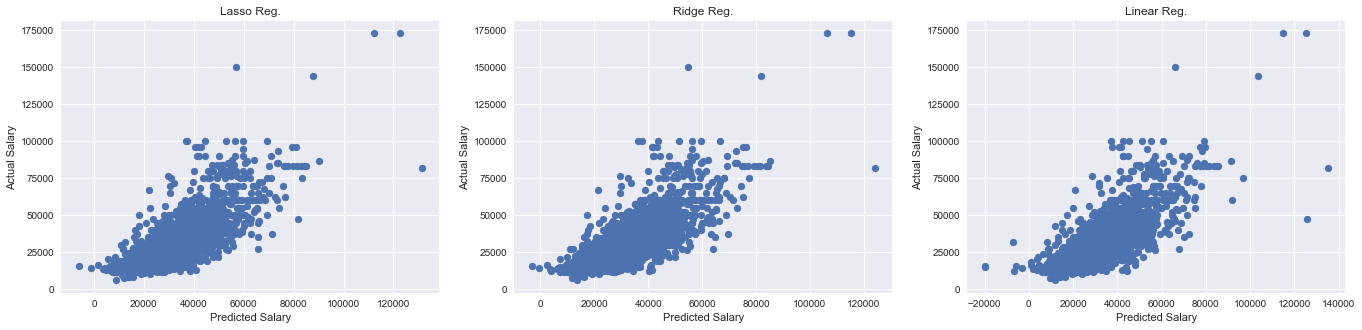

In [36]:
plt.figure(figsize=(23,5))
plt.subplot(131)
lasso = Lasso(alpha =1.0).fit(X_train, y_train)   
y_pred = list(lasso.predict(X_test))
plt.scatter(y_pred,y_test)
plt.xlabel('Predicted Salary')
plt.ylabel('Actual Salary')
plt.title('Lasso Reg.')

plt.subplot(132)
ridge = Ridge(alpha =1.0).fit(X_train, y_train)   
y_pred = list(ridge.predict(X_test))
plt.scatter(y_pred,y_test)
plt.xlabel('Predicted Salary')
plt.ylabel('Actual Salary')
plt.title('Ridge Reg.')

plt.subplot(133)
lr = LinearRegression().fit(X_train, y_train)
y_pred = list(lr.predict(X_test))
plt.scatter(y_pred,y_test)
plt.xlabel('Predicted Salary')
plt.ylabel('Actual Salary')
plt.title('Linear Reg.')

The plots above show the relationship between the predicted and actual salaries for the three top performing regression models.